In [1]:
# DATA PROCESSING, VISUALIZATION
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import string
import re

# MODELS, MODEL EVALUATION
from openai import OpenAI
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import os
import json
from typing import List
import requests
import pickle
import time
from tqdm import tqdm

In [2]:
import measure
from measure import baitness_measure

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Mateusz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [3]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [4]:
%run 0-Function-Helper.ipynb

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, 
    y_test,
    test_size=0.5,  # 50% of the original x_test size for validation
    random_state=42,
    stratify=y_test
)

In [6]:
with open("../file_path.txt", 'r') as file:
    file_path = file.read()

with open(file_path, 'r') as file:
    api_key = file.read()

client = OpenAI(
    api_key=api_key,
)

## 1000 dimensions

In [7]:
result_file_name = "batch_result_train_10_11_2024_1000_dimensions"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_train_df_1000 = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_train_df_1000.append(emb)


result_file_name = "batch_result_val_10_11_2024_1000_dimensions"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_val_df_1000 = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_val_df_1000.append(emb)

32000it [00:11, 2761.95it/s]
4000it [00:01, 2808.99it/s]


## Training with baitness score

In [16]:
def add_baitness_measure(x_data, x_vect):
    # Compute baitness measure and combine with vectorized data
    baitness_column = x_data.apply(baitness_measure).reset_index(drop=True)
    x_vect_and_bait = pd.DataFrame(x_vect)
    x_vect_and_bait['baitness_value'] = baitness_column.values  # Avoid extra reindexing
    x_vect_and_bait.columns = range(x_vect_and_bait.shape[1])  # Standardize column names
    return x_vect_and_bait

In [17]:
x_vect_and_baitness_measure = add_baitness_measure(x_train, embeddings_x_train_df_1000)
x_val_vect_and_bait = add_baitness_measure(x_val, embeddings_x_val_df_1000)

0.88 & 0.897 & 0.858 & 0.877 & 0.949 \
{'Accuracy': 0.88025, 'Precision': 0.8971668415529905, 'Recall': 0.8580030105368791, 'F1 Score': 0.8771479866632469, 'ROC-AUC': 0.9493562546141191}

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2007
           1       0.90      0.86      0.88      1993

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



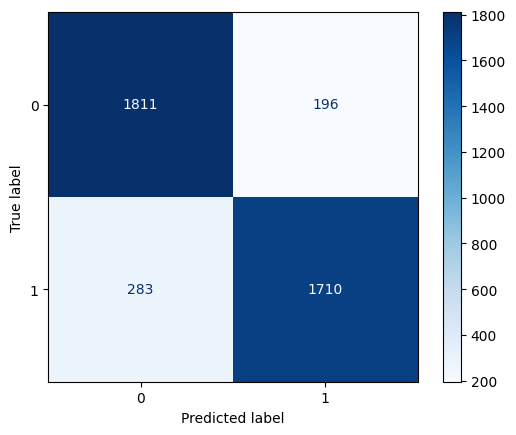

In [18]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_vect_and_baitness_measure, y_train)
pred_rf = RF.predict(x_val_vect_and_bait)
pred_rf_prob = RF.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.886 & 0.887 & 0.882 & 0.885 & 0.954 \
{'Accuracy': 0.8855, 'Precision': 0.8874305906108026, 'Recall': 0.8820873055694932, 'F1 Score': 0.8847508807247108, 'ROC-AUC': 0.9541335631361485}

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2007
           1       0.89      0.88      0.88      1993

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



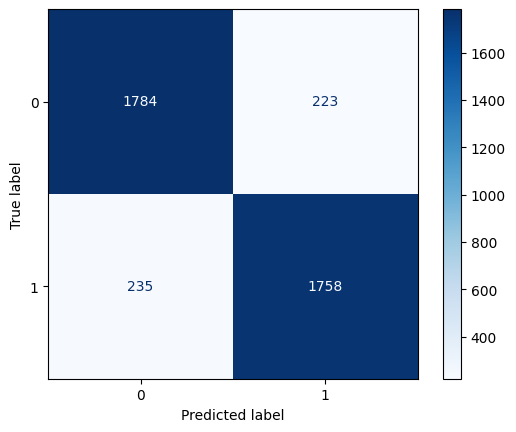

In [19]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(x_vect_and_baitness_measure, y_train)
pred_xgb = xgb_model.predict(x_val_vect_and_bait)
pred_xgb_prob = xgb_model.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

## 3000 dimensions

In [66]:
result_file_name = "batch_result_train_10_11_2024"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_train_df_3000 = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_train_df_3000.append(emb)

result_file_name = "batch_result_val_10_11_2024"
result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
embeddings_x_val_df_3000 = []
with open(result_file_name, 'r') as file:
    for line in tqdm(file):
        emb = json.loads(line.strip())['response']['body']['data'][0]['embedding']
        embeddings_x_val_df_3000.append(emb)

32000it [00:35, 895.85it/s]
4000it [00:04, 889.86it/s]


In [21]:
x_vect_and_baitness_measure = add_baitness_measure(x_train, embeddings_x_train_df_3000)
x_val_vect_and_bait = add_baitness_measure(x_val, embeddings_x_val_df_3000)

0.878 & 0.897 & 0.851 & 0.874 & 0.949 \
{'Accuracy': 0.8775, 'Precision': 0.8974087784241143, 'Recall': 0.8514801806322128, 'F1 Score': 0.8738414006179197, 'ROC-AUC': 0.9485984953315679}

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2007
           1       0.90      0.85      0.87      1993

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



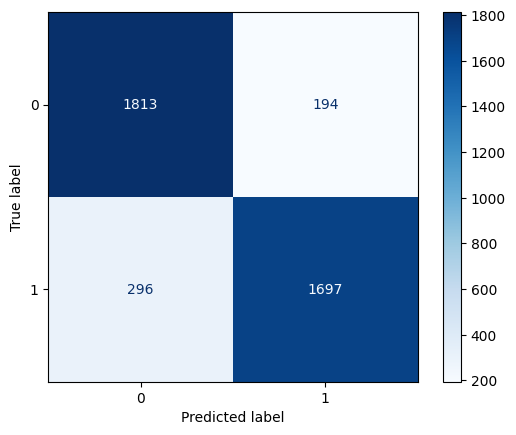

In [22]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_vect_and_baitness_measure, y_train)
pred_rf = RF.predict(x_val_vect_and_bait)
pred_rf_prob = RF.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.889 & 0.895 & 0.881 & 0.888 & 0.957 \
{'Accuracy': 0.889, 'Precision': 0.8945491594498217, 'Recall': 0.8810837932764677, 'F1 Score': 0.8877654196157736, 'ROC-AUC': 0.9572529763489603}

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2007
           1       0.89      0.88      0.89      1993

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



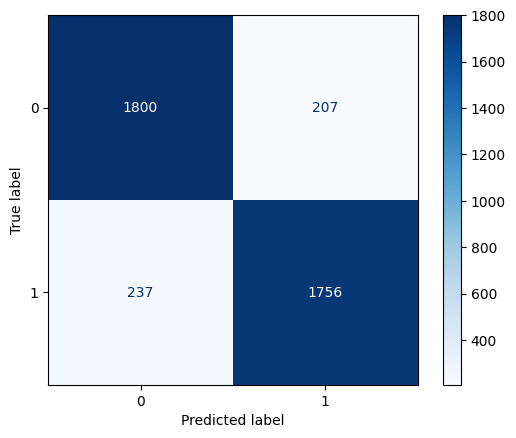

In [23]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(x_vect_and_baitness_measure, y_train)
pred_xgb = xgb_model.predict(x_val_vect_and_bait)
pred_xgb_prob = xgb_model.predict_proba(x_val_vect_and_bait)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])

## Training with multiple informativeness measures

## 1000 dimensions

In [8]:
metrics_functions = {
    "n_words": measure.words_count,
    "cw_percentage": measure.common_words_ratio,
    "capitals_ratio": measure.capital_letters_ratio,
    "capitals_count":measure.capital_words_count,
    "bait_punct": measure.clickbait_punctuation_count,
    "nonbait_punct": measure.nonclickbait_punctuation_count,
    "numbers": measure.numbers_count,
    "2nd_pronouns": measure.pronouns_2nd_person_count,
    "superlatives": measure.superlatives_ratio,
    "speculatives": measure.speculatives_count,
    "bait_words": measure.baiting_words_count,
    "polarity": measure.polarity_score,
    "subjectivity": measure.subjectivity_score,
    "fres": measure.flesch_reading_ease_score,
    "batness_measures": baitness_measure,
}


In [9]:
def add_baitness_measure(x_data, x_df_emb, function_, function_name):
    baitness_column = x_data.apply(function_).reset_index(drop=True)
    x_df_emb[function_name] = baitness_column.values  # Avoid extra reindexing
    return x_df_emb

In [10]:
embeddings_x_train_df_1000_with_measures = pd.DataFrame(embeddings_x_train_df_1000)
for function_name, function in metrics_functions.items():
    embeddings_x_train_df_1000_with_measures = add_baitness_measure(x_train, embeddings_x_train_df_1000_with_measures, function, function_name)

embeddings_x_val_df_1000_with_measures = pd.DataFrame(embeddings_x_val_df_1000)
for function_name, function in metrics_functions.items():
    embeddings_x_val_df_1000_with_measures = add_baitness_measure(x_val, embeddings_x_val_df_1000_with_measures, function, function_name)

In [11]:
embeddings_x_train_df_1000_with_measures.head()

,0,1,2,3,4,5,6,7,8,9,...,nonbait_punct,numbers,2nd_pronouns,superlatives,speculatives,bait_words,polarity,subjectivity,fres,batness_measures
0,-0.024125,-0.066810,-0.018174,-0.008578,-0.042817,-0.025238,0.076920,0.036215,-0.027859,0.009629,...,0,0,0,0.000000,0,0,0.000000,0.000000,63.36,0.141853
1,0.035256,0.023147,-0.012991,-0.013152,-0.056851,0.008751,-0.015345,0.050146,-0.004717,-0.002510,...,2,0,0,0.000000,0,0,0.230000,0.370000,52.87,0.154261
2,0.009653,-0.036139,-0.021925,-0.022145,0.031028,0.010248,0.021156,0.022731,0.002260,0.021137,...,1,0,0,0.000000,0,0,0.000000,0.000000,52.87,0.111280
3,-0.027686,0.008709,-0.016980,0.014564,0.016205,-0.040673,-0.009895,0.009411,-0.044174,0.026592,...,0,0,1,0.333333,0,0,0.200000,0.200000,68.77,0.373094
4,-0.011716,-0.011513,-0.029347,-0.034509,-0.014521,0.055320,0.012997,0.031014,0.016320,0.075847,...,0,0,2,0.000000,0,4,0.166667,0.166667,95.17,0.549022


In [12]:
embeddings_x_val_df_1000_with_measures.head()

,0,1,2,3,4,5,6,7,8,9,...,nonbait_punct,numbers,2nd_pronouns,superlatives,speculatives,bait_words,polarity,subjectivity,fres,batness_measures
0,-0.032989,0.016568,-0.021444,-0.031382,-0.001429,-0.039823,-0.036443,0.033266,0.018766,0.006017,...,1,0,0,0.0,1,0,0.00,0.00,61.33,0.265605
1,-0.018057,-0.009831,-0.018088,0.003290,0.004031,-0.010332,-0.043639,0.038486,-0.053087,-0.021840,...,0,0,0,0.0,2,0,0.35,0.65,72.32,0.499703
2,-0.025451,-0.041972,-0.012029,-0.001244,-0.019253,0.003492,-0.072584,0.007859,-0.008685,0.014011,...,0,0,0,1.0,1,0,1.00,0.30,85.69,0.564317
3,0.020177,-0.009787,-0.018970,-0.037379,0.031784,0.027353,-0.019220,0.047509,0.006750,0.052585,...,0,0,1,0.0,0,1,0.20,0.20,115.13,0.544084
4,0.000492,-0.055524,-0.027158,0.003410,0.033864,0.013475,-0.012944,0.023117,-0.036113,0.007961,...,0,1,0,0.0,0,0,0.50,1.00,68.77,0.394864


In [13]:
embeddings_x_train_df_1000_with_measures.columns = range(embeddings_x_train_df_1000_with_measures.shape[1])
embeddings_x_val_df_1000_with_measures.columns = range(embeddings_x_val_df_1000_with_measures.shape[1])

0.898 & 0.916 & 0.876 & 0.895 & 0.961 \
{'Accuracy': 0.898, 'Precision': 0.9155742003146303, 'Recall': 0.8760662318113397, 'F1 Score': 0.8953846153846153, 'ROC-AUC': 0.9614052772146459}

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2007
           1       0.92      0.88      0.90      1993

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



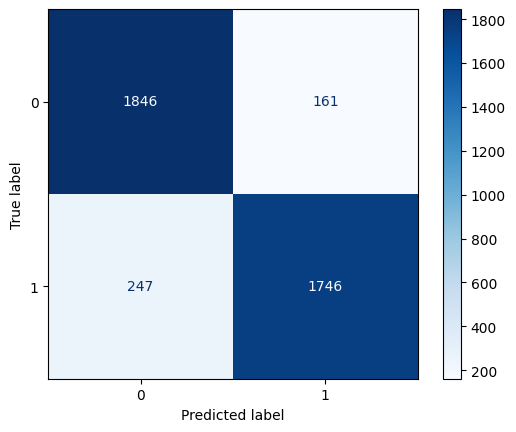

In [16]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df_1000_with_measures, y_train)
pred_rf = RF.predict(embeddings_x_val_df_1000_with_measures)
pred_rf_prob = RF.predict_proba(embeddings_x_val_df_1000_with_measures)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.91 & 0.922 & 0.896 & 0.909 & 0.969 \
{'Accuracy': 0.9105, 'Precision': 0.9224806201550387, 'Recall': 0.8956347215253387, 'F1 Score': 0.9088594704684317, 'ROC-AUC': 0.9687558672593739}

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2007
           1       0.92      0.90      0.91      1993

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



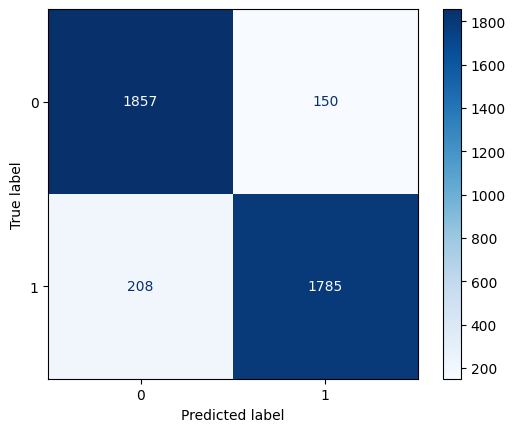

In [14]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df_1000_with_measures, y_train)
pred_xgb = xgb_model.predict(embeddings_x_val_df_1000_with_measures)
pred_xgb_prob = xgb_model.predict_proba(embeddings_x_val_df_1000_with_measures)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1], 'best_model_conf_combined')

In [ ]:
#Save models

In [20]:
with open('../final_models/RF_1000_dimensions_and_informativeness_measures.pkl', 'wb') as rf_file:
    pickle.dump(RF, rf_file)

In [21]:
with open('../final_models/XGB_1000_dimensions_and_informativeness_measures.pkl', 'wb') as xgb_file:
    pickle.dump(xgb_model, xgb_file)

## 3000 dimensions

In [67]:
embeddings_x_train_df_3000_with_measures = pd.DataFrame(embeddings_x_train_df_3000)
for function_name, function in metrics_functions.items():
    embeddings_x_train_df_3000_with_measures = add_baitness_measure(x_train, embeddings_x_train_df_3000_with_measures, function, function_name)

embeddings_x_val_df_3000_with_measures = pd.DataFrame(embeddings_x_val_df_3000)
for function_name, function in metrics_functions.items():
    embeddings_x_val_df_3000_with_measures = add_baitness_measure(x_val, embeddings_x_val_df_3000_with_measures, function, function_name)

In [68]:
embeddings_x_train_df_3000_with_measures.columns = range(embeddings_x_train_df_3000_with_measures.shape[1])
embeddings_x_val_df_3000_with_measures.columns = range(embeddings_x_val_df_3000_with_measures.shape[1])

0.893 & 0.914 & 0.867 & 0.89 & 0.963 \
{'Accuracy': 0.89325, 'Precision': 0.9142857142857143, 'Recall': 0.8670346211741093, 'F1 Score': 0.8900334792686068, 'ROC-AUC': 0.9629430460523142}

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      2007
           1       0.91      0.87      0.89      1993

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



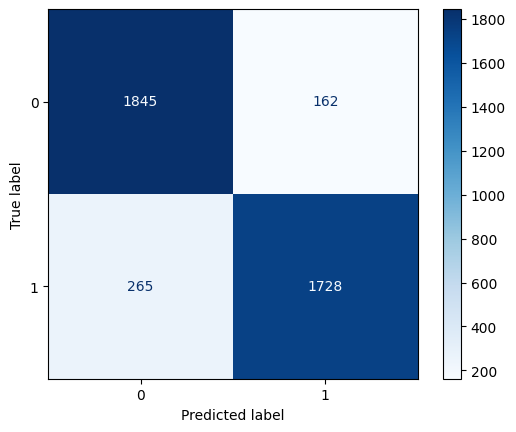

In [69]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(embeddings_x_train_df_3000_with_measures, y_train)
pred_rf = RF.predict(embeddings_x_val_df_3000_with_measures)
pred_rf_prob = RF.predict_proba(embeddings_x_val_df_3000_with_measures)
create_summary_for_model_metrics(y_val, pred_rf, pred_rf_prob[:,1])

0.908 & 0.92 & 0.893 & 0.906 & 0.969 \
{'Accuracy': 0.908, 'Precision': 0.9198966408268734, 'Recall': 0.8931259407927747, 'F1 Score': 0.9063136456211812, 'ROC-AUC': 0.9689916201473467}

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2007
           1       0.92      0.89      0.91      1993

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



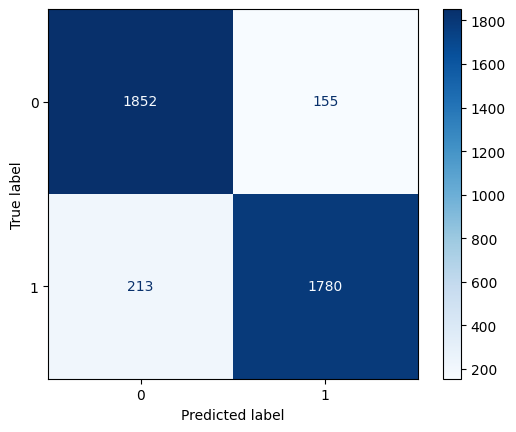

In [70]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(embeddings_x_train_df_3000_with_measures, y_train)
pred_xgb = xgb_model.predict(embeddings_x_val_df_3000_with_measures)
pred_xgb_prob = xgb_model.predict_proba(embeddings_x_val_df_3000_with_measures)
create_summary_for_model_metrics(y_val, pred_xgb, pred_xgb_prob[:,1])